# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [42]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

Populating the interactive namespace from numpy and matplotlib


In [43]:
# all_data = './jetyak_new_bedford/cleandata/all_interpolated.csv'
# fh_data = './jetyak_new_bedford/cleandata/fh_interpolated.csv'
# nb_data = './jetyak_new_bedford/cleandata/nb_interpolated.csv'

# ctd_geo = './jetyak_new_bedford/cleandata/ctd_geo.csv'
# gga_geo = './jetyak_new_bedford/cleandata/gga_geo.csv'
# nit_geo = './jetyak_new_bedford/cleandata/nit_geo.csv'
# op_geo = './jetyak_new_bedford/cleandata/op_geo.csv'
# air_geo = './jetyak_new_bedford/cleandata/air_geo.csv'


all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'



In [44]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.392000e+04           nan 
    01s03  0005   7.548858e+03   7.631168e+05 
    02s15  0009   5.081686e+03   4.649933e+03 
    06s47  0029   4.773445e+03   1.056530e+00 
    07s55  0034   4.772505e+03   3.845263e-03 
    08s47  0038   4.772501e+03   4.100327e-09 
Runtime:     08s47
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.830524e+03   4.100327e-09 
    03s15  0012   8.618696e+02   2.174113e+02 
    06s25  0024   8.445479e+02   1.897950e-03 
    07s09  0027   8.445479e+02   1.564683e-09 
Runtime:     07s09
Optimization status: Converged

Optimization restart 2/2, f = 844.547911881
  rbf.         |               value  |  constraints  |  priors
  variance     |  12.932545597557958  |      +ve      |        
  lengths

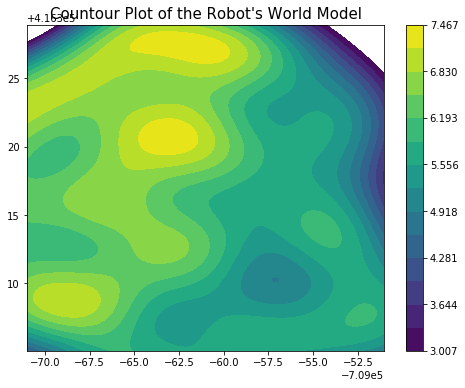

In [45]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

In [46]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

LENGTH = 0.001#12.76#4.10
VAR = np.var(z)#20.47#12.93#

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000
print np.mean(zvals), np.var(zvals)

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'mean'
gp_world = GPModel(ranges, 4.10, 12.93)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 12.93, 
                    lengthscale = 4.10, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(-709070.99900000007, -709051.0340000001, 20)
x2observe = np.linspace(416305.07100000005, 416328.92400000006, 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

print ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = LENGTH, 
              init_variance = VAR, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05,
              sample_step = 1.0,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 175)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()


(1458, 2) (1458, 1)
19.965 23.853
6.370657765702211 0.3330176189875886
World max value 7.467374396955659 at location [-709064.919  416322.422]
(-709061.0165000001, 416316.99750000006, 0)
[ 0 ] Current Location:   (-709061.0165000001, 416316.99750000006, 0)
Number of rollouts: 4271 	 Size of tree: 12884
Current predicted max and value: 	[[0. 0.]] 	0.0
[ 1 ] Current Location:   (-709060.3903280861, 416319.9314237779, 1.3605263157894738)
Number of rollouts: 3742 	 Size of tree: 11086
Current predicted max and value: 	[-709070.999  416305.071] 	0.0
[ 2 ] Current Location:   (-709057.7500470231, 416318.50702358555, -0.49473684210526314)
Number of rollouts: 2967 	 Size of tree: 8796
Current predicted max and value: 	[-709070.999  416305.071] 	0.0
[ 3 ] Current Location:   (-709060.618829833, 416317.629478607, -2.844736842105263)


KeyboardInterrupt: 